# July 13th, 2018
## Benjamin Adam Catching
## Andino Lab Rotation
## Polio DIPs Project

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

import skimage.filters
import skimage.morphology
import skimage.io
import skimage.segmentation
import skimage.exposure
import skimage.feature
import pprint
import scipy.ndimage
from skimage.draw import circle

In [318]:
# Function that makes a circle
def make_circle(image, center_x, center_y, radius, value=1):
    """On the input image, create a binary circle of given radius at the given center"""
    
    points_x = len(image[0, :])
    points_y = len(image[:, 0])
    new_image=np.array(image[:, :])
    for (i,j), value in np.ndenumerate(new_image):
        dist_x = i - center_x
        dist_y = j - center_y
        dist = np.sqrt(dist_x**2 + dist_y**2)
        if dist <= radius:
            new_image[i, j] =  new_image[i, j] - 200
    return new_image

class Bulk_droplet:
    """Create an image object from the read in file"""
    
    def __init__(self, filename, micron_per_pixel=1, gfp_thresh=0, multi_channel=False,
                testing=False):
        """Initialize the image data"""
        
        # Define input image attributes
        self.filename = filename
        self.image = skimage.io.imread(filename)
        self.micron_per_pixel = micron_per_pixel
        self.gfp_thresh = gfp_thresh
        self.shape = self.image.shape
        self.multi_channel = multi_channel
        
    def droplet_segment(self, testing=False):
        """Return droplets and their properties"""
        
        # If the image has multiple channels, choose the channel to determine droplets from
        if self.multi_channel:
            bright_channel = int(input('Input brightfield channel: '))
            image_bright = (self.image)[:, :, bright_channel]
        else:
            image_bright = self.image

        # Find the Otsu threshold
        bright_thresh_otsu = skimage.filters.threshold_otsu(image_bright)
        
        # Label thesholded images
        bright_threshold = image_bright > bright_thresh_otsu
        image_labeled, number_labels = skimage.measure.label(bright_threshold, background=0, return_num=True)
        
        # Get the properties of the labeled regions
        image_props = skimage.measure.regionprops(image_labeled)

        # Create a blank region of the original image
        blank_background= np.zeros(image_bright.shape)
        
        for index, prop in enumerate(image_props):
            #print(prop.area)
            # If the region properties are within the threshold
            if prop.area >= 10000 and prop.eccentricity <= 0.50:
                # Select the region
                #print(index)
                temp_seg = image_labeled==index+1
                filled_seg = temp_seg
                # Add the temp region
                blank_background = blank_background + filled_seg
                                
        # Fill the holes of the image
        image_droplets = scipy.ndimage.binary_fill_holes(blank_background)
        image_droplets = skimage.morphology.closing(image_droplets, selem=skimage.morphology.disk(2))
        image_droplets = skimage.morphology.erosion(image_droplets, selem=skimage.morphology.disk(2))
        
        
        # If testing is True, show the image
        if testing:
            with sns.axes_style("dark"):
                # Define the number of pixels in a millimeter
                mm = (1 / self.micron_per_pixel) * 500

                # Define the number of ticks
                num_x_ticks = (image_bright.shape)[1] // mm + 1
                num_y_ticks = (image_bright.shape)[0] // mm + 1
                plt.imshow(image_droplets)
                plt.xticks(np.arange(0, (image_bright.shape)[1], mm), np.arange(0, num_x_ticks))
                plt.yticks(np.arange(0, (image_bright.shape)[0], mm), np.arange(0, num_y_ticks))
                plt.xlabel("x-axis (mm)")
                plt.ylabel("y-axis (mm)")
                plt.title("Segmented Droplets")
                plt.show()
            
        image_labeled, number_labels = skimage.measure.label(image_droplets, background=0, return_num=True)
        
        # Get the properties of the labeled regions
        image_props = skimage.measure.regionprops(image_labeled)
        
        d = 3
        for i in range(d):
            image_props
            
        return image_labeled, image_props
    
    def find_brightfield_cells(self):
        """Return the brightfield cells"""
        
        # Call the labeled black-white droplet image and the associated properties
        image_labeled, image_props = self.droplet_segment()
        
        # Define the droplet images
        labeled_droplets, number_droplets = skimage.measure.label(image_labeled, background=0, return_num=True)
        bright_droplet_props = skimage.measure.regionprops(labeled_droplets, image_bright)
        
        return labeled_droplets, bright_droplet_props

In [319]:
# Define the test series of images
HeLa_Fast_filenames = glob.glob("../../data/20180710_Microfludic_picture/HeLa_Fast/*.tif")
HeLa_Fast_filenames = sorted(HeLa_Fast_filenames)
HeLa_Fast_filenames

['../../data/20180710_Microfludic_picture/HeLa_Fast/10_40X_DIC.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/10_40X_sytox.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/1_20X_DIC.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/1_20X_stox.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/1_40X_DIC.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/1_40X_sytox.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/2_40X_DIC.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/2_40X_sytox.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/3_40X_DIC.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/3_40X_sytox.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/4_40X_DIC.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/4_40X_sytox.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/5_40X_DIC.tif',
 '../../data/20180710_Microfludic_picture/HeLa_Fast/5_40X_sytox.tif',
 '../../data/20180710_Microfludic

In [320]:
# Test the current function on the first set of images
test_image = Bulk_droplet(HeLa_Fast_filenames[4], gfp_thresh=50, multi_channel=True)

Input brightfield channel: 0


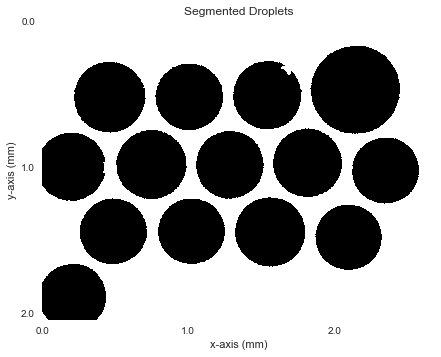

In [352]:
test_image_labeled, test_image_props = test_image.droplet_segment(testing=True)

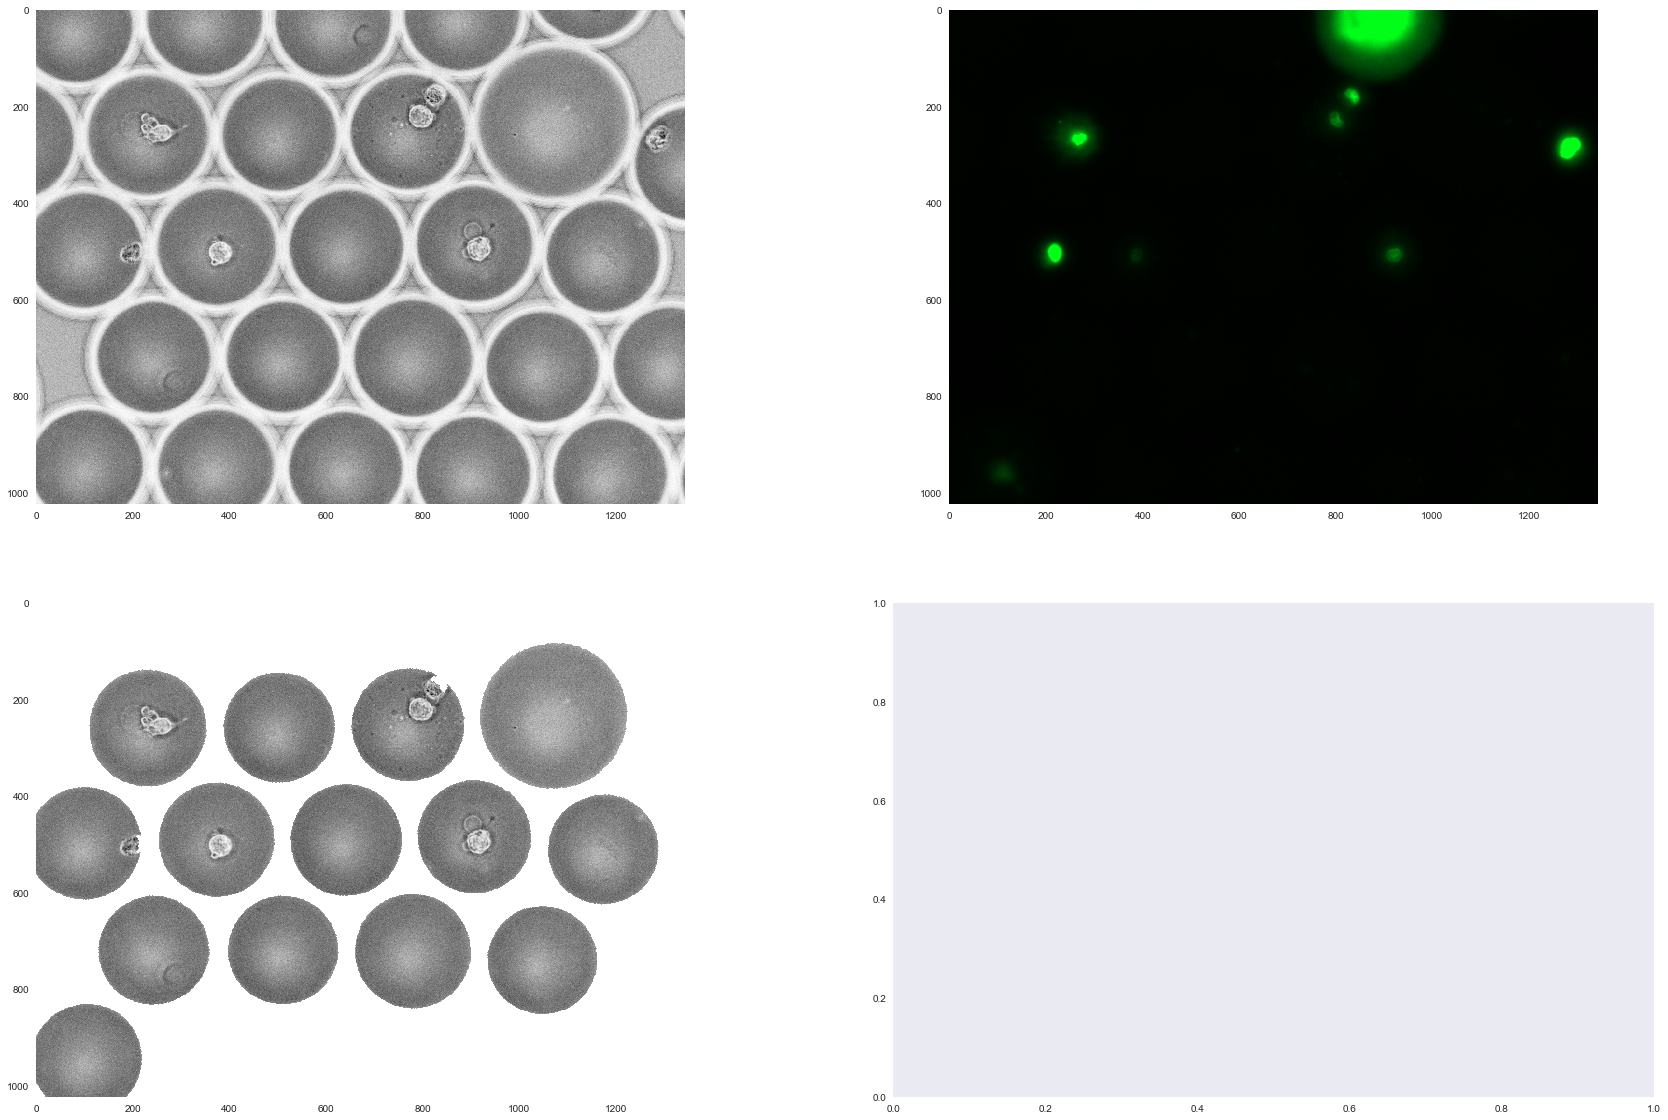

In [353]:
num = 4
test_raw_image = skimage.io.imread(HeLa_Fast_filenames[num])
test_gfp_image = skimage.io.imread(HeLa_Fast_filenames[num+1])
with sns.axes_style('dark'):
    fig, ax = plt.subplots(2, 2, figsize=(30, 20))
    ax[0, 0].imshow(test_raw_image[:, :, 0])
    ax[0, 1].imshow(test_gfp_image[:, :])
    #ax[1, 0].imshow(test_image_labeled)
    binary_image = np.empty_like(test_image_labeled)
    binary_image[test_image_labeled != 0] = 1
    # Make the segmented 
    segmented_image = binary_image * test_raw_image[:, :, 1]
    ax[1, 0].imshow(segmented_image)
    #ax[1, 1].imshow(test_gfp_image[:, :, 1] * segmented_image)
    plt.show()

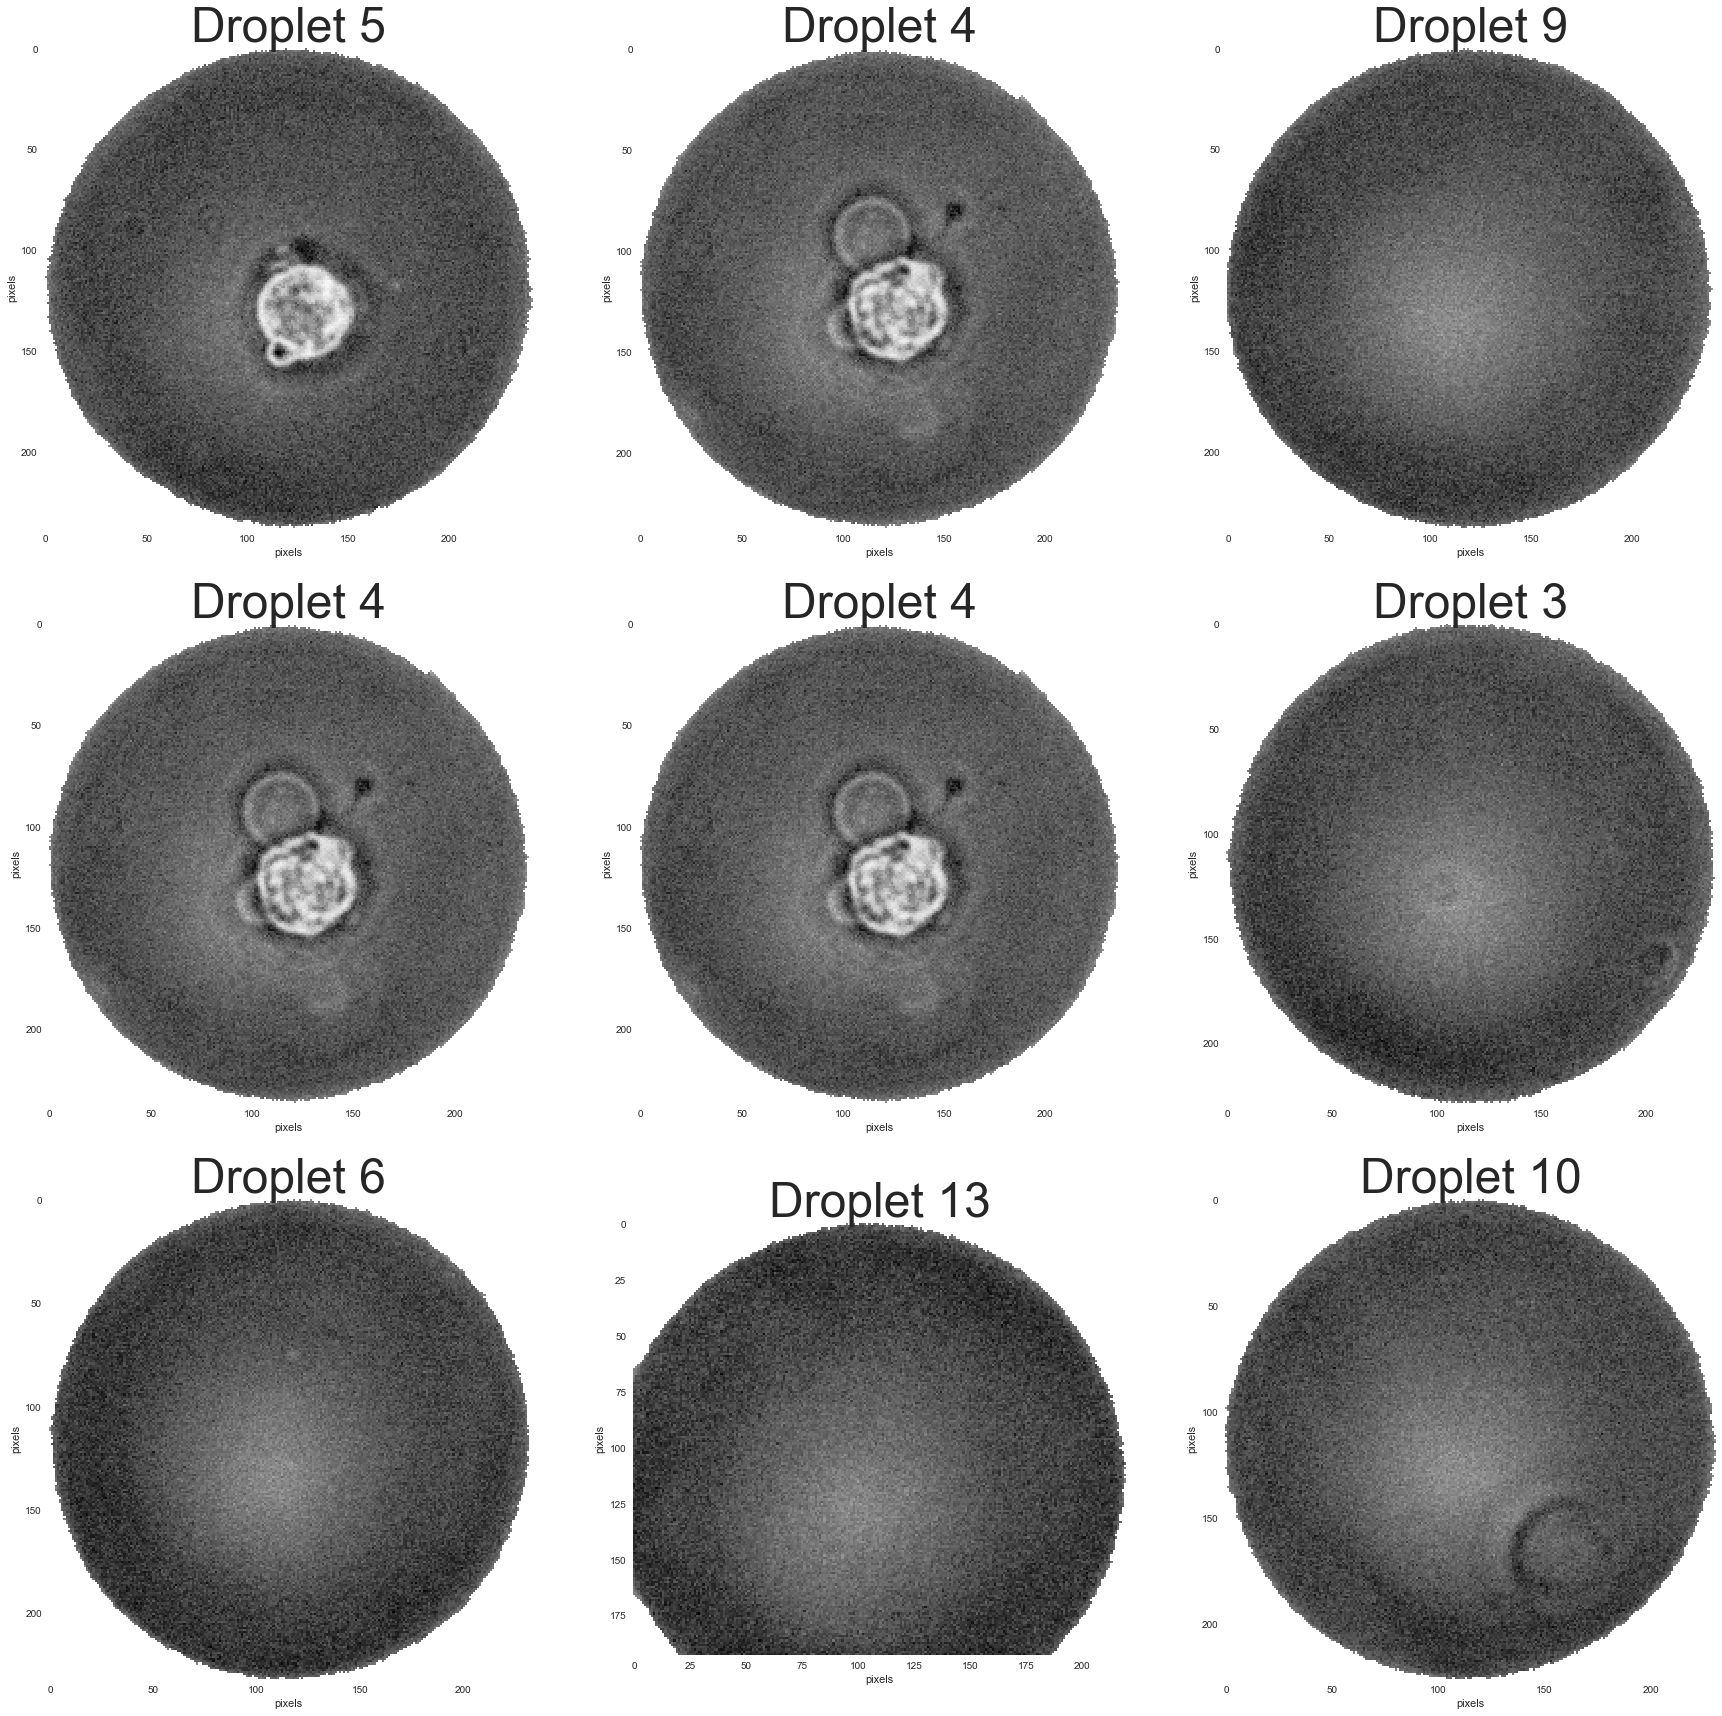

In [364]:
bright_droplet_props = skimage.measure.regionprops(test_image_labeled, test_raw_image[:, :, 0])
gfp_droplet_props = skimage.measure.regionprops(test_image_labeled, test_gfp_image[:, :, 1])
# Choose the set of random droplets that will be tested
random_values = np.random.randint(len(test_image_props), size=(3,3))

with sns.axes_style("dark"):
    fig, ax = plt.subplots(3, 3, figsize = (30, 30))
    for i in range(3):
        for j in range(3):
            selection = random_values[i, j]
            #print(i, j, selection)
            #print(bright_droplet_props[selection].eccentricity)
            ax[i, j].imshow(bright_droplet_props[selection].intensity_image)
            ax[i, j].set_title("Droplet %i" % selection, size=48)
            ax[i, j].set_xlabel('pixels')
            ax[i, j].set_ylabel('pixels')
plt.show()

There appears to be an issue that if the cell is around the exterior of the droplet, the segmentation will not include the cell in the droplet. This can be overcome by finding the effective radius of the droplet and drawing a black circle of that radius around the centroid of the droplet.

In [367]:
# List of segmented droplets 
bright_droplets = []
gfp_droplets = []
for index, prop in enumerate(bright_droplet_props):
    bright_droplets.append(prop.intensity_image)
    gfp_droplets.append(gfp_droplet_props[index].intensity_image)

Now all images can be analyzed individually for characteristics

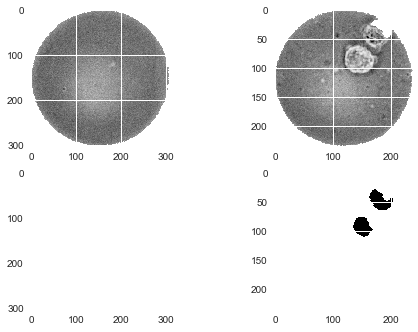

In [369]:
fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(bright_droplets[0])
ax[0, 1].imshow(bright_droplets[1])
ax[1, 0].imshow(gfp_droplets[0] > 50)
ax[1, 1].imshow(gfp_droplets[1] > 50)
plt.show()

Now there is a test set of droplets to try segmentation.

The coarse function should work well enough to segment. Turn it into a function and apply it to the class.

In [370]:
def segment_image(temp_image):
    """From an black-white image, return segmented image"""
    
    temp_image[temp_image==0] = temp_image.mean()
    temp_thresh = skimage.filters.threshold_mean(temp_image)
    thresh_image = temp_image < temp_thresh
    
    if thresh_image.max() != 0:
        """temp_thresh = skimage.filters.threshold_otsu(initial_image)

        temp_bw = initial_image > temp_thresh"""
        
        #temp_bw = ndi.binary_fill_holes(temp_bw)

        temp_distance = ndi.distance_transform_edt(thresh_image)

        temp_local_maxi = peak_local_max(temp_distance, labels=temp_bw, footprint=np.ones((8, 8)), indices=False)

        temp_markers = ndi.label(temp_local_maxi)[0]

        temp_labels = skimage.segmentation.watershed(-temp_distance, temp_markers, mask=temp_bw)

        return temp_labels
    else:
        return initial_image

/Users/adam/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 234 but corresponding boolean dimension is 303


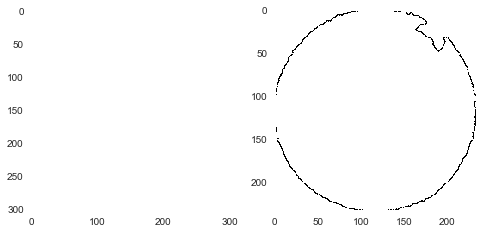

'no_cell_seg = segment_image(droplets[0])\ncell_seg = segment_image(droplets[1])'

In [418]:
no_cell_droplet = bright_droplets[0]
cell_droplet = bright_droplets[1]

# Apply gaussian to cells
skimage.filters.gaussian(no_cell_droplet, sigma=.5)
skimage.filters.gaussian(cell_droplet, sigma=.5)

# Set values
offset=40
blocksize = 41
selem = skimage.morphology.disk(100)

no_cell_droplet[no_cell_droplet==0] = no_cell_droplet.mean()
#no_cell_temp_thresh = skimage.filters.threshold_local(no_cell_droplet, blocksize, offset=offset)
no_cell_temp_thresh = skimage.filters.sobel(no_cell_droplet)
#no_cell_temp_thresh = skimage.filters.rank.otsu(no_cell_droplet, selem)
no_cell_thresh_image = no_cell_droplet < no_cell_temp_thresh

cell_droplet[no_cell_droplet==0] = cell_droplet.mean()
cell_temp_thresh = skimage.filters.sobel(cell_droplet)
#cell_temp_thresh = skimage.filters.threshold_local(cell_droplet, blocksize, offset=offset)
#cell_temp_thresh = skimage.filters.rank.otsu(cell_droplet, selem)
cell_thresh_image = cell_droplet < cell_temp_thresh

fig, ax = plt.subplots(1, 2)
ax[0].imshow(no_cell_thresh_image)
ax[1].imshow(cell_thresh_image)
plt.show()
"""no_cell_seg = segment_image(droplets[0])
cell_seg = segment_image(droplets[1])"""

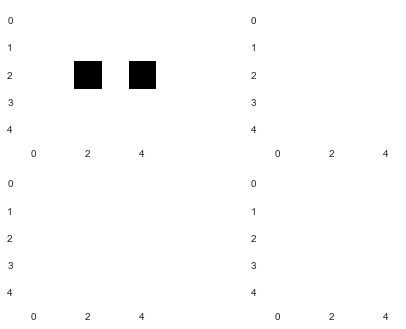

In [205]:
with sns.axes_style('dark'):
    fig, ax = plt.subplots(2, 2)
    test_array = np.zeros((5, 5))
    test_array[2, 2] = 1
    test_array[2, 4] = 1
    ax[0, 0].imshow(test_array)
    for i in range(2):
        test_array = skimage.morphology.dilation(test_array, selem=skimage.morphology.selem.disk(2))
    ax[0, 1].imshow(test_array)
    for i in range(2):
        test_array = skimage.morphology.erosion(test_array)
    ax[1, 0].imshow(test_array)
    test_array = skimage.morphology.erosion(test_array)
    ax[1, 1].imshow(test_array)
    plt.show()

In [328]:
(test_gfp_image[:, :, 1] > 50).shape

(1024, 1344)

In [340]:
rgb_image.shape

(3, 1024, 1344)